In [1]:
import pandas as pd

def train_test_split_time(df: pd.DataFrame, aus_port: str, for_port: str, test_length: int = 9):
    """
    Splits time-series data into train and test sets for a given city pair.

    Parameters:
        df: DataFrame with the dataset!
        aus_port: It refers to the Australian Port provided in the route.
        for_port: It refers to the Foreign Port provided in the route.
        horizon (int): Number of months to keep for testing. Kept as 9 (in between 6-12 months).
    """
    route_df = (df[((df["AustralianPort"] == aus_port) & (df["ForeignPort"] == for_port))]
                .sort_values("MonthYear").reset_index(drop=True))

    train = route_df.iloc[:-test_length]
    test = route_df.iloc[-test_length:]

    return train, test

In [2]:
df = pd.read_csv("../../data/aeroconnect_cleaned.csv")
train, test = train_test_split_time(df=df, aus_port="Sydney", for_port="Auckland")

print("Train range:", train["MonthYear"].min(), "→", train["MonthYear"].max())
print("Test range:", test["MonthYear"].min(), "→", test["MonthYear"].max())

Train range: 1985-01-01 → 1988-09-01
Test range: 1988-10-01 → 1989-06-01


In [14]:
def create_lag_features(series, n_lags=12):
    """
    This method prepares the input for time-series forecasting by creating "lag features". Each lag column corresponds to value of "PassengersTotal" from previous time-steps, which can be used as predictors for the current value.
    :param series: DataFrame.
    :param n_lags: Number of lagged time-steps to generate features for.
    :return: DataFrame with lag features!!
    """
    df = pd.DataFrame(series)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df['PassengersTotal'].shift(lag)
    df = df.dropna()
    return df

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# --- Linear Regression ---
def evaluate_linear_regression_mae(df, n_lags=12, min_history=24):
    results = []

    for (aus, foreign), group in df.groupby(["AustralianPort", "ForeignPort"]):
        group = group.sort_values("MonthYear")

        # Skips short series with not a lot of data to make predictions.
        if len(group) < min_history:
            continue

        # Creates Lag Features
        df_lags = create_lag_features(group['PassengersTotal'], n_lags=n_lags)
        if len(df_lags) < 2:
            continue

        # Split Train/Test --> Test = Last 9 Months
        test_size = min(9, len(df_lags)//2)
        train = df_lags.iloc[:-test_size]
        test = df_lags.iloc[-test_size:]

        X_train = train.drop(columns='PassengersTotal').values
        y_train = train['PassengersTotal'].values
        X_test = test.drop(columns='PassengersTotal').values
        y_test = test['PassengersTotal'].values

        model = LinearRegression()
        model.fit(X_train, y_train)
        forecast = model.predict(X_test)

        mae = mean_absolute_error(y_test, forecast)
        weight = y_test.sum()
        results.append({"port_pair": (aus, foreign), "forecast": forecast, "mae": mae, "weight": weight})

    total_weight = sum(r["weight"] for r in results)
    weighted_mae = sum(r["mae"] * r["weight"] for r in results) / total_weight
    return pd.DataFrame(results), weighted_mae

In [25]:
df_results, overall_mae = evaluate_linear_regression_mae(df)
print(df_results)
print("Weighted MAE:", overall_mae)
print("Total MAE: ", df_results["mae"].sum())

total_passengers_test = test["PassengersTotal"].sum()
print("Total passengers in test set:", total_passengers_test)

print("Accuracy = ", round(100 - ((df_results["mae"].sum() / total_passengers_test) * 100), 2), "%")


                    port_pair  \
0       (Adelaide, Abu Dhabi)   
1       (Adelaide, Amsterdam)   
2          (Adelaide, Athens)   
3        (Adelaide, Auckland)   
4         (Adelaide, Bahrain)   
..                        ...   
182   (Townsville, Frankfurt)   
183      (Townsville, London)   
184  (Townsville, Manchester)   
185        (Townsville, Rome)   
186   (Townsville, Singapore)   

                                              forecast         mae  weight  
0    [18.92658634972788, 17.008867509450795, 15.343...   14.174401      47  
1    [32.16066894083065, 49.90292106550558, -6.6954...   19.157183     246  
2    [37.33866022464494, 55.43731933685798, 34.4081...   19.515691     433  
3    [1949.2421456733443, 2083.7983809735256, 1974....  444.273855    9970  
4    [16.16977344151358, 19.06471257637584, 13.8022...    8.621142     192  
..                                                 ...         ...     ...  
182  [66.92947843984578, 67.90479361537615, 119.303...   26.2510

In [26]:
import matplotlib.pyplot as plt

def plot_port_pair_forecast(df, aus_port, foreign_port, n_lags=12, min_history=24):
    group = df[(df["AustralianPort"] == aus_port) & (df["ForeignPort"] == foreign_port)]
    group = group.sort_values("MonthYear")

    if len(group) < min_history:
        print(f"Not enough history for {aus_port}-{foreign_port}")
        return

    df_lags = create_lag_features(group['PassengersTotal'], n_lags=n_lags)
    if len(df_lags) < 2:
        print(f"Not enough lagged data for {aus_port}-{foreign_port}")
        return

    test_size = min(9, len(df_lags)//2)
    train = df_lags.iloc[:-test_size]
    test = df_lags.iloc[-test_size:]

    X_train = train.drop(columns='PassengersTotal').values
    y_train = train['PassengersTotal'].values
    X_test = test.drop(columns='PassengersTotal').values
    y_test = test['PassengersTotal'].values

    model = LinearRegression()
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)

    plt.figure(figsize=(10, 5))
    plt.plot(group["MonthYear"].iloc[n_lags: -test_size], y_train, label="Train (Actual)", color="blue")
    plt.plot(group["MonthYear"].iloc[-test_size:], y_test, label="Test (Actual)", color="black", linestyle="dashed")
    plt.plot(group["MonthYear"].iloc[-test_size:], forecast, label="Forecast", color="red")

    plt.title(f"Passenger Forecast: {aus_port} → {foreign_port}")
    plt.xlabel("Date")
    plt.ylabel("Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()


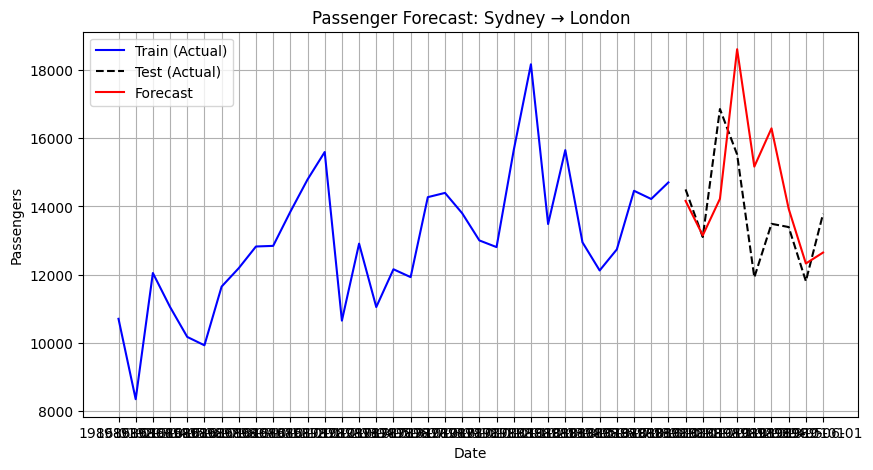

In [28]:
plot_port_pair_forecast(df=df, aus_port="Sydney", foreign_port="London")